# (12104) Chesley orbit determination test

In [1]:
import grss
prop = grss.prop
fit = grss.fit

In [2]:
import numpy as np
np.set_printoptions(precision=40, linewidth=np.inf)
import matplotlib.pyplot as plt

In [3]:
body_id = '12104'
init_sol, init_cov, nongrav_info = fit.get_sbdb_info(body_id)
body_radius = 0.0

In [4]:
optical_obs_file = None
t_min_tdb = None
t_max_tdb = None
debias = False
debias_lowres = True
deweight = True
eliminate = False
max_obs_per_night = 4
verbose = True
obs_array_optical, observer_codes_optical = fit.get_optical_obs_array(body_id, optical_obs_file, t_min_tdb, t_max_tdb, debias, debias_lowres, deweight, eliminate, max_obs_per_night, verbose)
obs_array_radar, observer_codes_radar = fit.get_radar_obs_array(body_id, t_min_tdb, t_max_tdb, verbose)

Skipped 28 observations 
	 28 of which were non-geocentric occultations or space-based observations, 
	 0 were either roving or radar observations (radar is handled separately), 
	 0 of which were outside the specified time range.
No debiasing needed for 1814 observations. Debiased 1273 observations. No biasing information for 10 observations.
Applied default weight of 1 arcsec to 145 CCD observations
Deweighted 798 observations as part of deweighting scheme.


In [5]:
n_iter_max = 10
de_kernel = 441
de_kernel_path = grss.utils.default_kernel_path(de_kernel)
fit_sim = fit.FitSimulation(init_sol, init_cov, obs_array_optical, observer_codes_optical, obs_array_radar, observer_codes_radar, n_iter_max=n_iter_max, de_kernel=de_kernel, de_kernel_path=de_kernel_path, radius=body_radius, nongrav_info=nongrav_info)

In [6]:
fit_sim.filter_lsq()

Iteration		Unweighted RMS		Weighted RMS 		Chi-squared		Reduced Chi-squared
1			 0.431			 0.478			 1417.348			 0.229
2			 0.431			 0.478			 1416.637			 0.229
Converged without rejecting outliers. Starting outlier rejection now.
3			 0.403			 0.431			 1146.668			 0.186
4			 0.402			 0.431			 1145.946			 0.186
Converged after rejecting outliers.


In [7]:
fit_sim.print_summary()

Summary of the orbit fit calculations at iteration 4 (of 4):
RMS unweighted: 0.40239356870847465
RMS weighted: 0.4313121762502249
chi-squared: 1145.9459912313032
reduced chi-squared: 0.18621156828587962
square root of reduced chi-squared: 0.4315223844551747
t: MJD 57738.0 TDB
Fitted Variable		Initial Value			Uncertainty			Fitted Value 			Uncertainty			Change				Change (sigma)
e			2.41594472929e-02		2.94002577556e-08 		2.41594450667e-02		2.81525481248e-08 		-2.22618629087e-09		-0.076
q			2.93828018638e+00		8.99390539895e-08 		2.93828019370e+00		8.62603609326e-08 		+7.32099936229e-09		+0.081
tp			5.68199558150e+04		3.84031128759e-04 		5.68199558139e+04		3.72421377247e-04 		-1.10604742076e-06		-0.003
om			7.80621777762e+01		1.66301228578e-05 		7.80621783143e+01		1.68823034026e-05 		+5.38146991858e-07		+0.032
w			1.83000116206e+02		7.37415160678e-05 		1.83000115450e+02		7.16556791157e-05 		-7.56414237912e-07		-0.010
i			1.11515692119e+01		3.36526255700e-06 		1.11515693528e+01		3.4229218302

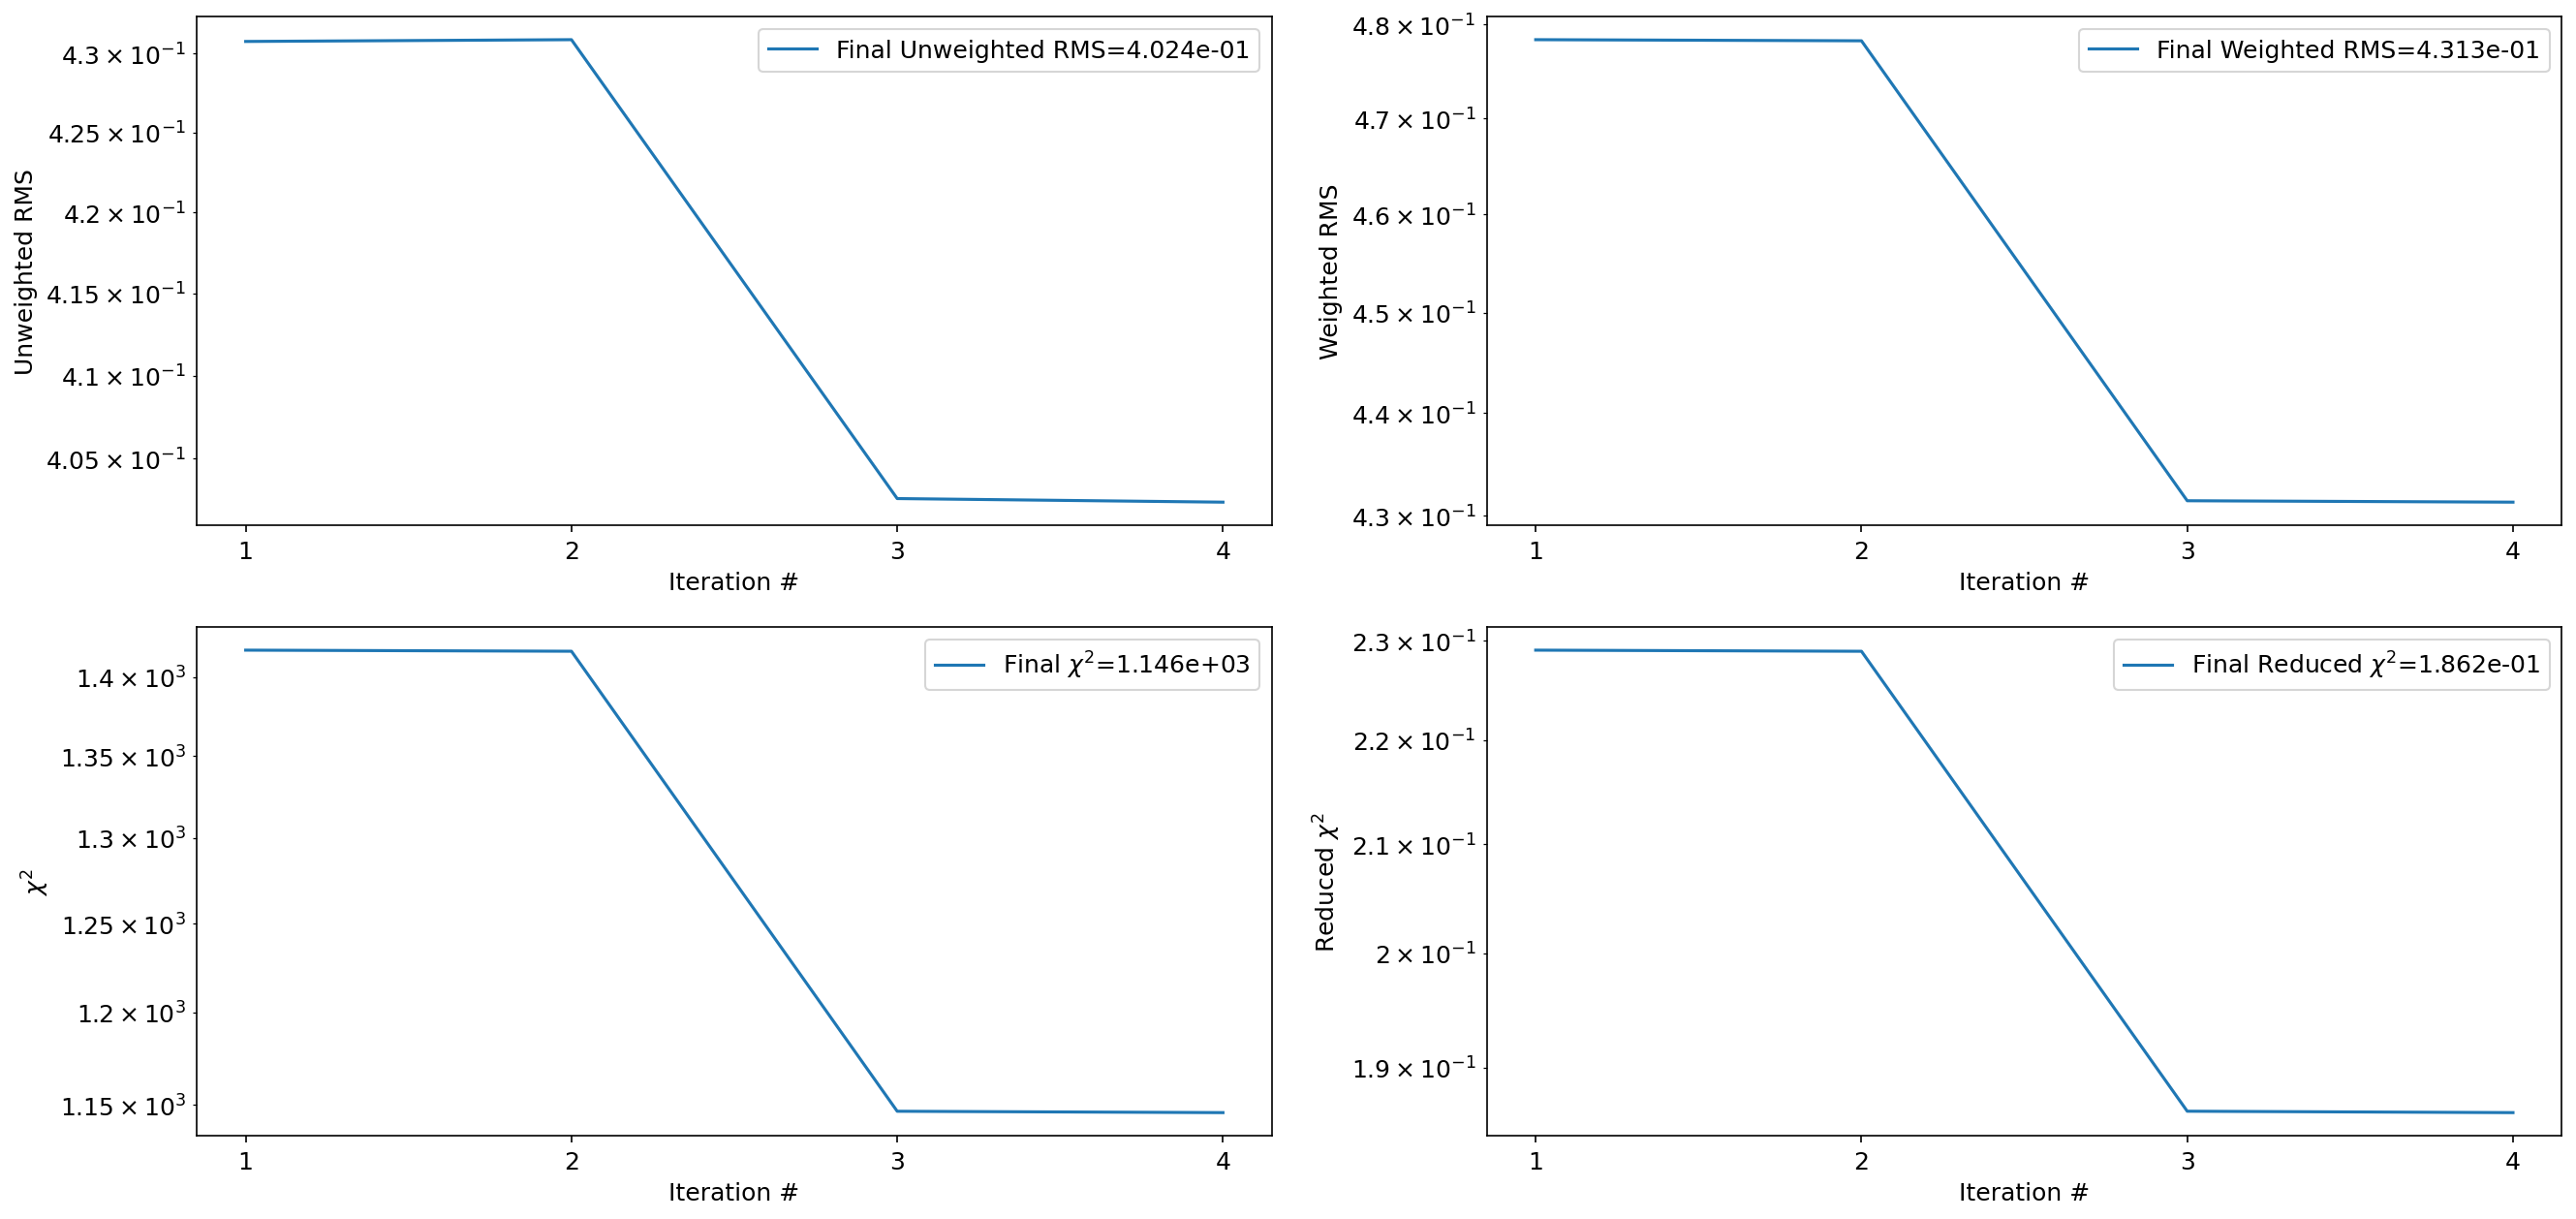

In [8]:
fit_sim.plot_summary(auto_close=True)

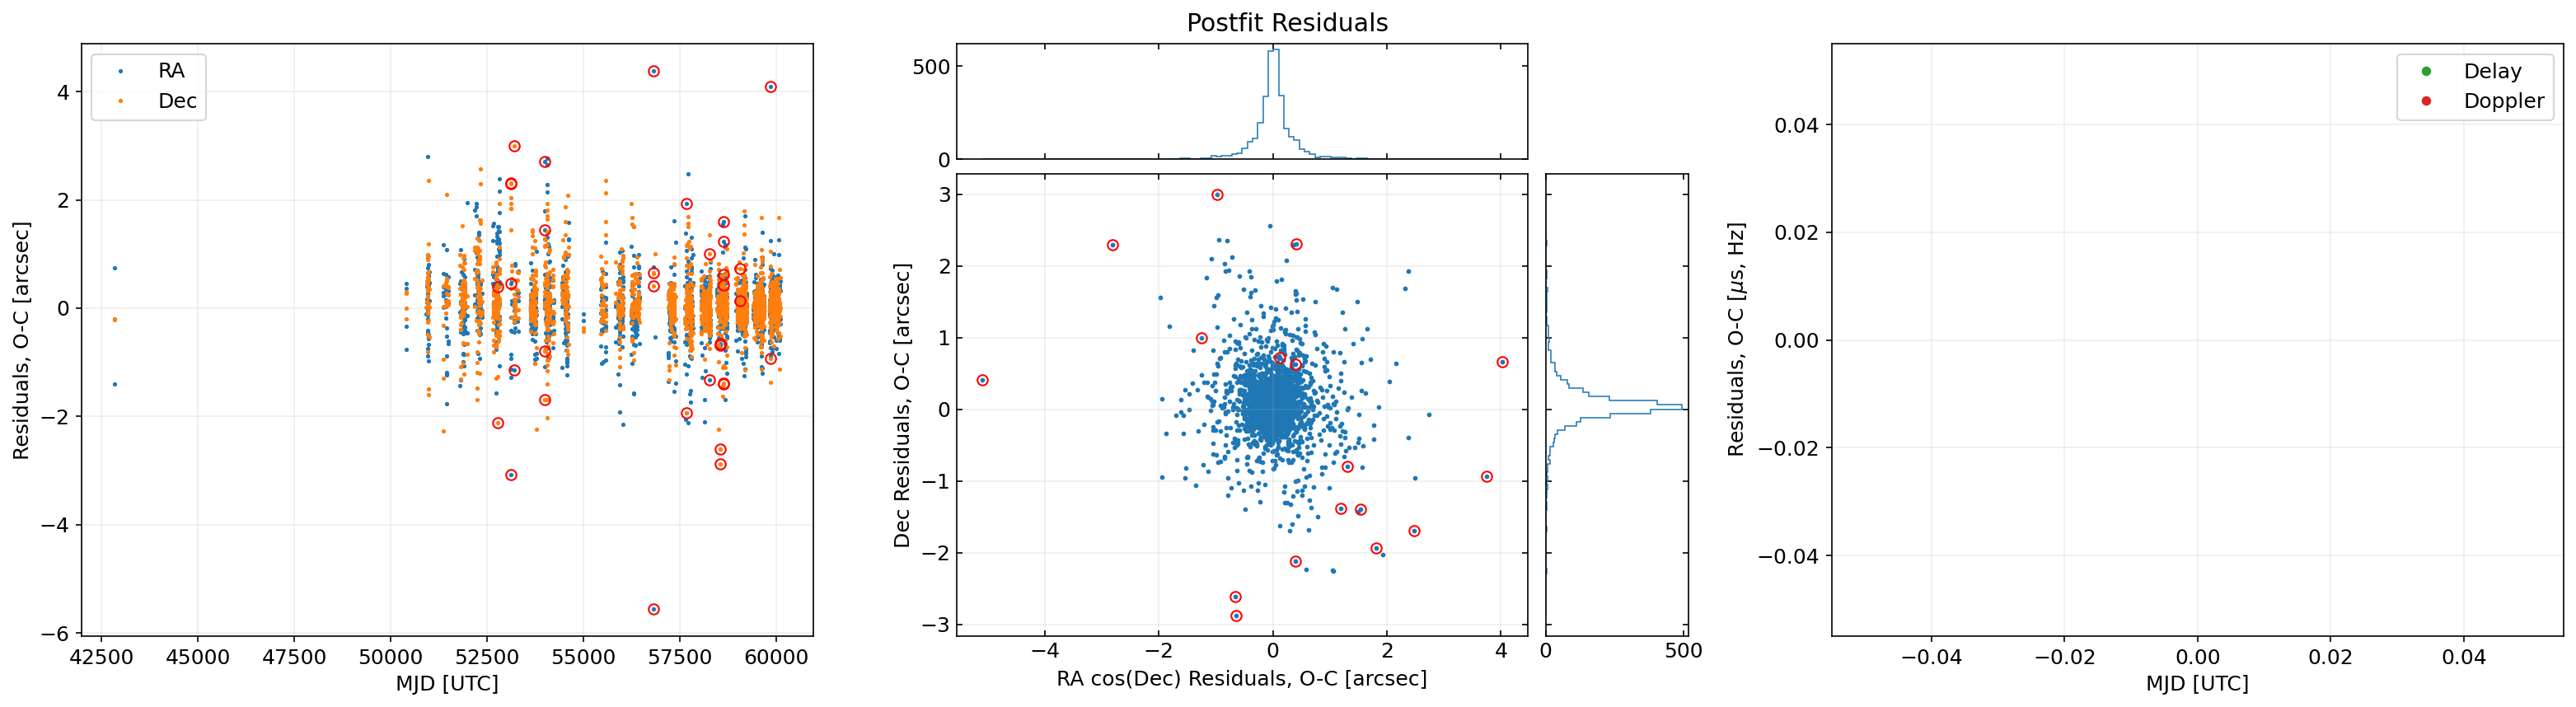

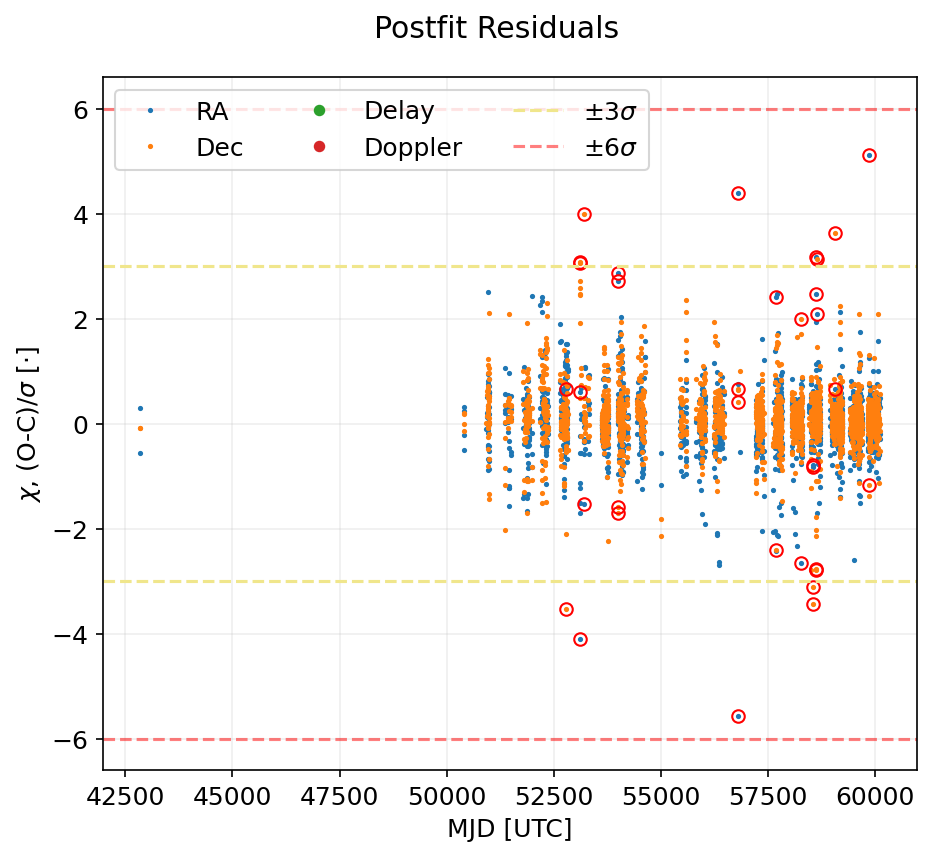

In [9]:
fit_sim.iters[-1].plot_iteration_summary(title='Postfit Residuals', auto_close=True)

In [10]:
mean_0 = np.array(list(init_sol.values())[1:])
cov_0 = init_cov
mean_f = np.array(list(fit_sim.x_nom.values()))
cov_f = fit_sim.covariance

maha_dist_f, maha_dist_0, bhattacharya, bhatt_coeff = fit.get_similarity_stats(mean_0, cov_0, mean_f, cov_f)
print(f'Mahalonobis distance between JPL and GRSS solution: {maha_dist_f:0.2f}')
print(f'Mahalonobis distance between GRSS and JPL solution: {maha_dist_0:0.2f}')
print(f'Bhattacharya distance between JPL and GRSS solution: {bhattacharya:0.4f}')
print(f'Bhattacharya coefficient between JPL and GRSS solution: {bhatt_coeff:0.4f}')

Mahalonobis distance between JPL and GRSS solution: 0.12
Mahalonobis distance between GRSS and JPL solution: 0.12
Bhattacharya distance between JPL and GRSS solution: 0.0022
Bhattacharya coefficient between JPL and GRSS solution: 0.9978


In [11]:
assert maha_dist_f < 3.0
assert maha_dist_0 < 3.0
assert bhattacharya < 0.10
assert bhatt_coeff > 0.90